Logical Structure

In [28]:
import numpy as np
import math
import sys
import statistics
import csv
import matplotlib.pyplot as plt

In [29]:
gt = {"or": 0.5}

def stan_accuracy(resultFile, var_name, gt, benchmark_name):
    file_handle = open(resultFile, "r")
    lines = file_handle.readlines()

    answer = 0
    for i in lines:
        current = i.split()
        if current != []:
            if current[0] == var_name:
                answer = float(current[1])

    handle2 = open("../stan_results.txt", "a")
    handle2.writelines(benchmark_name + "," + var_name + "," + str(abs(gt - answer)) + "\n")
    handle2.close()
    return abs(gt - answer)
    
def AQUA_accuracy(benchmark_name, result_file, gt):
    file_handle = open(result_file, "r")
    lines = file_handle.readlines()

    min_error = 10000000    
    for i in lines:
        cur = float(i[:-1])
        if abs(gt - cur) < min_error:
            min_error = abs(gt - cur)
    return min_error

def Dice_accuracy(benchmark_name, result_file, gt, position, flag):
    file_handle = open(result_file, "r")
    lines = file_handle.readlines()
    
    min_error = 100000000
    min_line = ""
    for i in lines:
        bits = float(i.split(",")[0])
        pieces = (math.log2(float((i.split(",")[1]))))
        if pieces < bits/2.0:
            continue
        btime = float(i.split(",")[-1])
        if btime > 1200:
            continue
        cur = float(i.split(",")[position])
        if (flag == None):
            if abs(gt - cur) <= min_error:
                min_error = abs(gt - cur)
                min_line=i
        elif (float(i.split(",")[flag[1]]) == flag[0]):
            if abs(gt - cur) <= min_error:
                min_error = abs(gt - cur)
                min_line = i
        else:
            continue
    return min_error

def WebPPL_accuracy(benchmark, method, gt):
    min_error = 1000000000
    a = 0
    for number in range(15, 26):
        ans = []
        filename = benchmark+"/output_"+method+"_"+str(number)+".txt"
        try:
            file_handle = open(filename, "r")
        except:
            continue

        lines = file_handle.readlines()
        for i in lines:
            if i.split() == []:
                continue
            if i.split()[0] == "{":
                if int(i.split()[-2]) > 1200000:
                    continue
                ans.append(abs(float(i.split()[2][:-1]) - gt))
            else:
                continue
        if ans == []:
            continue
        
        cur = statistics.mean(ans)
        if (cur < min_error):
            a = number
            min_error = cur
    return min_error

def stan_iterations(filename):
    f = open(filename, "r")
    a = f.readlines()[1]
    iter = a[a.find("(") + 1:a.find(")")]
    print(iter)
    return int(iter)

In [30]:
# Collecting Stan numbers
stan_files = [5, 10, 15]
stan_res = []

for i in stan_files:
    stan_res.append(stan_accuracy(f"or/results_{i}.txt", "prior1", gt["or"], f"or_{i}"))

stan_res

[6.0139999999986316e-05, 0.0013600999999999752, 0.0019025499999999473]

In [31]:
# Collecting HyBit numbers
dice_files2 = [i for i in range(5, 55, 5)]

dice_res = []
for i in dice_files2:
    dice_res.append(Dice_accuracy(f"or_{i}", f"results_{i}.txt", 0.5, 2, None))

dice_res

[4.867660368668147e-07,
 4.771474356179972e-07,
 4.768468555571559e-07,
 4.768374622932114e-07,
 4.76837168472688e-07,
 4.768371591468146e-07,
 4.768371591468146e-07,
 4.768371591468146e-07,
 4.768371591468146e-07,
 4.768371591468146e-07]

In [32]:
# Collecting WebPPL numbers
webppl_files2 = [i for i in range(5, 55, 5)]
mcmc_res = []
for i in webppl_files2:
    mcmc_res.append(WebPPL_accuracy(f"or_webppl/or_{i}", "MCMC", gt["or"]))

smc_res = []
for i in webppl_files2:
    smc_res.append(WebPPL_accuracy(f"or_webppl/or_{i}", "SMC", gt["or"]))

mcmc_res, smc_res

([0.00042998874082466053,
  0.00022309103739437397,
  0.0009860988323602937,
  0.0010369503333704454,
  0.0016814922160924505,
  0.0007626843327180333,
  0.0020389350045837197,
  0.0014812613802465124,
  0.0016591638825716904,
  0.0016826791204184548],
 [0.005678808976441396,
  0.001050892124704661,
  0.0011231633178548695,
  0.0008718332371600579,
  0.0007773691729226262,
  0.0008111491847657027,
  0.0011019570334341866,
  0.0010997066790573774,
  0.0010261221499151207,
  0.0007244206796401586])

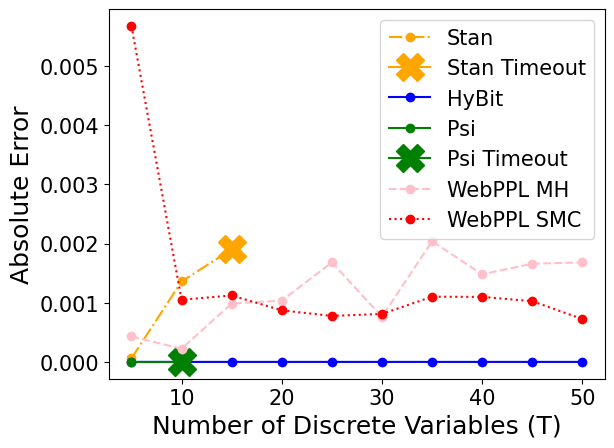

In [33]:
fig, ax = plt.subplots()

plt.rcParams.update({'font.size': 15})
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('xlabel', fontsize=18)
plt.rc('legend', fontsize=15)

ax.set_xlabel("Number of Discrete Variables (T)")
ax.set_ylabel("Absolute Error")
ax.plot(stan_files, stan_res, marker = "o", color="orange", linestyle="dashdot")
ax.plot([15], [stan_res[-1]], marker="X", markersize=20, color="orange")
ax.plot(dice_files2, dice_res, marker = "o", color="blue")
ax.plot([5, 10], [0, 0], marker = "o", color="green")

ax.plot([10], [0], marker="X", markersize=20, color="green")
ax.plot(webppl_files2, mcmc_res, marker="o", linestyle="dashed", color="pink")
ax.plot(webppl_files2, smc_res, marker="o", linestyle="dotted", color="red")

ax.legend(["Stan", "Stan Timeout", "HyBit", "Psi", "Psi Timeout", "WebPPL MH", "WebPPL SMC"])
fig.savefig("or_error.pdf", bbox_inches="tight")

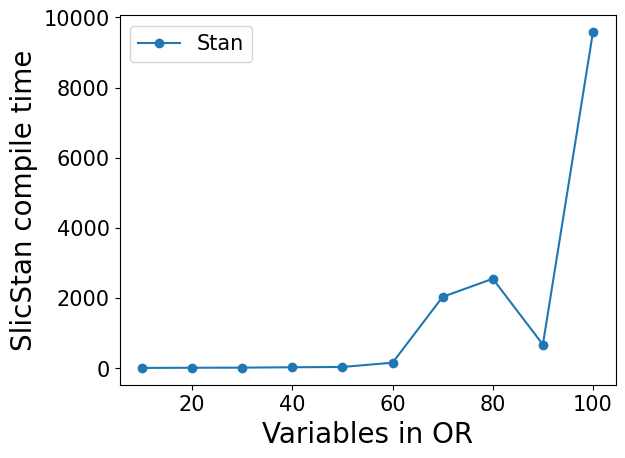

In [7]:
fig, ax = plt.subplots()

ax.set_xlabel("Variables in OR")
ax.set_ylabel("SlicStan compile time")
ax.plot(x, slicstan_time, marker = "o")

ax.legend(["Stan", "Dice"])
fig.savefig("or_slicstan.png", bbox_inches="tight")

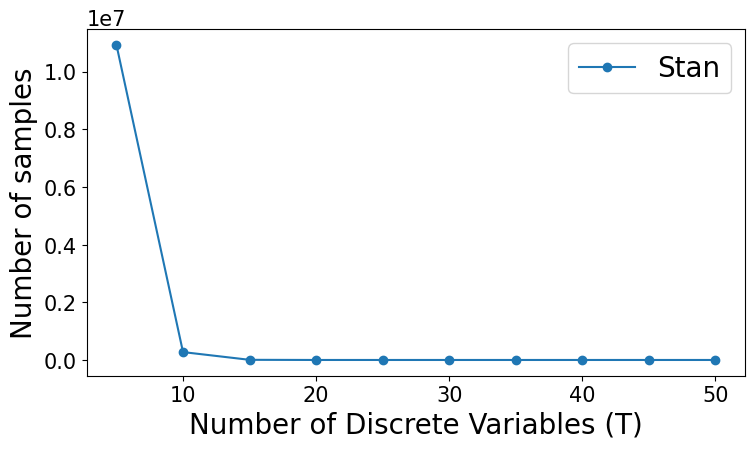

In [ ]:
fig, ax = plt.subplots()
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Number of Discrete Variables (T)")
ax.set_ylabel("Number of samples")
ax.plot(files2, iterations, marker = "o")

ax.legend(["Stan", "Dice"])
fig.savefig("or_samples.png", bbox_inches="tight")

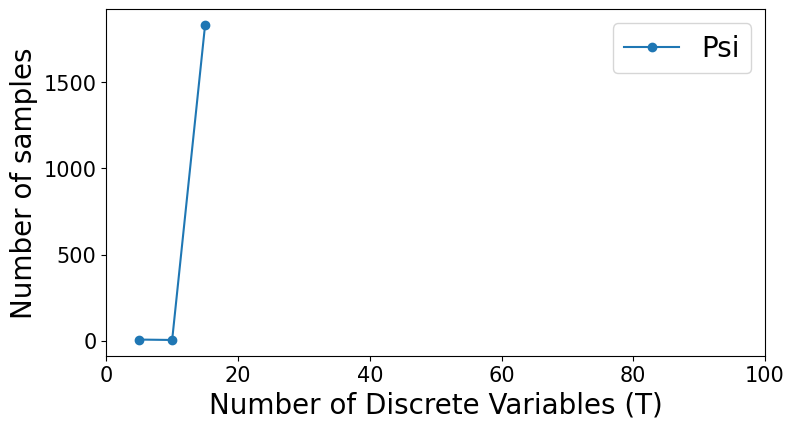

In [ ]:
fig, ax = plt.subplots()
plt.xlim(0, 100)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Number of Discrete Variables (T)")
ax.set_ylabel("Number of samples")
psi_time = [6.654, 4.320, 30*60+32]
ax.plot(files2[:3], psi_time, marker = "o")

ax.legend(["Psi", "Dice"])
fig.savefig("or_samples.png", bbox_inches="tight")